In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tqdm
import itertools
import pickle 
from pathlib import Path
import calendar

# Broker

In [2]:
class Broker:
    def __init__(self, price_df, capital, asset_ratio=0.5, fee=None):
        self.price_df = price_df.copy()
        self.capital = capital
        self.asset_ratio = asset_ratio
        self.fee = fee
        
        self.cash_ratio = 1 - self.asset_ratio

        self.portfolio_data = []
        
        # init
        init_index = self.price_df.index[0]
        self.asset_value = self.init_asset_value = self.capital * self.asset_ratio
        self.asset_amount = self.init_asset_amount = self.asset_value / self.price_df.loc[init_index, 'close']
        self.cash = self.init_cash = self.capital * self.cash_ratio
        
        # Initial portfolio historical data
        self.portfolio_data.append({
            'date': init_index,
            'nav': self.capital,
            'asset_value': self.asset_value,
            'asset_amount': self.asset_amount,
            'cash': self.cash
        })
    
    def asset_value_at(self, price=None):
        if price is None:
            return self.asset_value
        else:
            return self.asset_amount * price
    
    def nav_at(self, price=None):
        return self.asset_value_at(price) + self.cash
    
    def order(self, price, asset_amount, dt=None):
        # Calculate
        position_value = price * asset_amount
        
        if self.fee is not None:
            # Fee deduction
            if asset_amount > 0:
                posterior_cash = self.cash - position_value * (1 + self.fee / 100)
            else:
                posterior_cash = self.cash - position_value * (1 - self.fee / 100)
                
        posterior_asset_amount = self.asset_amount + asset_amount
        posterior_asset_value = posterior_asset_amount * price
        
        if posterior_cash < 0 or posterior_asset_value < 0:
            print('Fail to execute order', dt)
            return
        
        
        action = 'Buy' if asset_amount > 0 else 'Sell'
        last_asset_value = self.asset_value_at(price)
        last_asset_amount = self.asset_amount
        last_cash = self.cash
        last_nav = self.nav_at(price)
        
        # Update
        self.asset_amount = posterior_asset_amount
        self.asset_value = posterior_asset_value
        self.cash = posterior_cash
        
        self.portfolio_data.append({
            'date': dt,
            'price': price,
            'asset_value': last_asset_value,
            'asset_amount': last_asset_amount,
            'cash': last_cash,
            'nav': last_nav,

            'action': action,
            'position_value': position_value,

            'posterior_asset_value': self.asset_value_at(),
            'posterior_asset_amount': self.asset_amount,
            'posterior_cash': self.cash,
            'posterior_nav': self.nav_at(),
        })

    def buy(self, price, asset_amount, dt=None):
        if asset_amount < 0:
            raise NotImplementedError
        self.order(price, asset_amount, dt)
        
    def sell(self, price, asset_amount, dt=None):
        if asset_amount < 0:
            raise NotImplementedError
        self.order(price, -asset_amount, dt)
        
    def export_transaction(self):
        portfolio_df = pd.DataFrame(data=self.portfolio_data).set_index('date')
        return portfolio_df
    
    def export_price(self):
        portfolio_df = self.export_transaction()
        
        # Merge to price_df
        portfolio_price_df = self.price_df.merge(portfolio_df, how='left', left_index=True, right_index=True)
        portfolio_price_df[['asset_amount', 'cash']] = portfolio_price_df[['posterior_asset_amount', 'posterior_cash']].ffill()
        portfolio_price_df.loc[portfolio_price_df.index.min(), ['asset_amount', 'cash']] = (self.init_asset_amount, self.init_cash) 
        portfolio_price_df[['asset_amount', 'cash']] = portfolio_price_df[['asset_amount', 'cash']].ffill()
        portfolio_price_df['asset_value'] = portfolio_price_df['asset_amount'] * price_df['close']
        portfolio_price_df['nav'] = portfolio_price_df['asset_value'] + portfolio_price_df['cash']
        portfolio_price_df['price'] = price_df['close']
        portfolio_price_df = portfolio_price_df.groupby('date').last()
        portfolio_price_df.drop(columns=['action', 'position_value', 'posterior_asset_value',
               'posterior_asset_amount', 'posterior_cash', 'posterior_nav'], inplace=True)
        
        return portfolio_price_df

In [3]:
def buy_and_hold_by_ratio(price_df, asset_ratio, capital):
    cash_ratio = 1 - asset_ratio
    
    buy_and_hold_df = price_df.copy()
    
    price = buy_and_hold_df['close'].iloc[0]
    buy_and_hold_df['asset_amount'] = asset_ratio * capital / price
    buy_and_hold_df['asset_value'] = buy_and_hold_df['asset_amount'] * buy_and_hold_df['close']
    buy_and_hold_df['cash'] = cash_ratio * capital
    buy_and_hold_df['nav'] = buy_and_hold_df['asset_value'] + buy_and_hold_df['cash']
    return buy_and_hold_df

# Half month trigger

In [4]:
def half_month_grouper(dt):
    if dt.day <= 15:
        return pd.Timestamp(dt.year, dt.month, 15, 13, 0, 0)
    else:
        last_day = calendar.monthrange(dt.year, dt.month)[1]
        return pd.Timestamp(dt.year, dt.month, last_day, 13, 0, 0)
def calculate_half_month_std(price_df):
    daily_prices = price_df.resample('1d').last()['close']
    daily_price_df = pd.DataFrame(data=dict(price=daily_prices), index=daily_prices.index)

    daily_price_df['period'] = daily_price_df.index.map(half_month_grouper)
    daily_price_df['return'] = daily_price_df['price'].pct_change()
    periodically_return_stds = daily_price_df.groupby('period')['return'].apply(np.std)
    return periodically_return_stds

# Initial capital & fee

In [5]:
CAPITAL = 1000
FEE = 0.0

# BTC

In [33]:

price_df = pd.read_csv('dataset/BTCUSDT-1min.csv',
                 index_col='date',
                 parse_dates=['date'])
price_df = price_df[['open', 'high', 'low', 'close']]
price_df.index = price_df.index.map(lambda ts: pd.Timestamp(ts.year, ts.month, ts.day, ts.hour, ts.minute, 0))
price_df.sort_index(inplace=True)
price_df

,open,high,low,close
date,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48
...,...,...,...,...
2021-09-04 15:56:00,49845.77,49856.55,49821.46,49821.46
2021-09-04 15:57:00,49821.47,49836.10,49800.86,49800.88
2021-09-04 15:58:00,49800.88,49826.93,49793.07,49826.92


In [34]:
price_df

,open,high,low,close
date,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48
...,...,...,...,...
2021-09-04 15:56:00,49845.77,49856.55,49821.46,49821.46
2021-09-04 15:57:00,49821.47,49836.10,49800.86,49800.88
2021-09-04 15:58:00,49800.88,49826.93,49793.07,49826.92


In [35]:

buy_and_hold_price_df = buy_and_hold_by_ratio(price_df, asset_ratio=1.0, capital=CAPITAL).resample('1d').last()
buy_and_hold_price_df

,open,high,low,close,asset_amount,asset_value,cash,nav
date,,,,,,,,
2017-08-17,4285.08,4285.08,4285.08,4285.08,0.23466,1005.537982,0.0,1005.537982
2017-08-18,4108.37,4108.37,4108.37,4108.37,0.23466,964.071168,0.0,964.071168
2017-08-19,4139.98,4139.98,4139.98,4139.98,0.23466,971.488779,0.0,971.488779
2017-08-20,4069.13,4086.29,4069.13,4086.29,0.23466,958.889869,0.0,958.889869
2017-08-21,4016.00,4016.00,4016.00,4016.00,0.23466,942.395600,0.0,942.395600
...,...,...,...,...,...,...,...,...
2021-08-31,47130.89,47130.89,47100.89,47100.89,0.23466,11052.707041,0.0,11052.707041
2021-09-01,48819.73,48855.41,48801.40,48810.52,0.23466,11453.889259,0.0,11453.889259
2021-09-02,49295.08,49295.08,49234.25,49246.64,0.23466,11556.229291,0.0,11556.229291


count    98.000000
mean      0.037115
std       0.017972
min       0.008048
25%       0.024528
50%       0.033903
75%       0.046814
max       0.114123
Name: return, dtype: float64

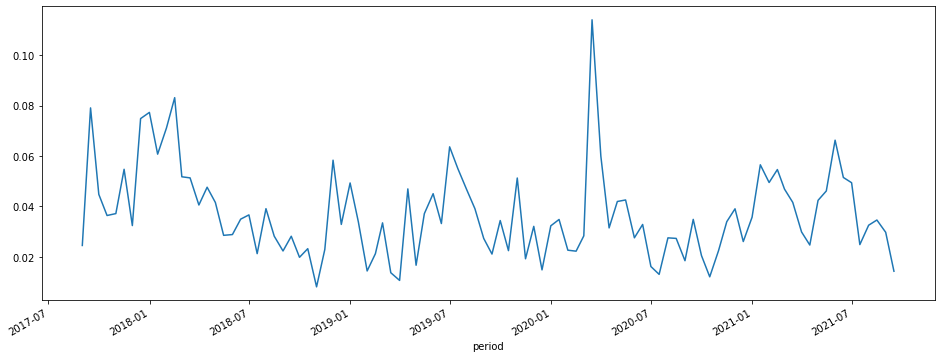

In [36]:
broker = Broker(price_df, capital=CAPITAL, asset_ratio=1.0, fee=FEE)
periodically_return_stds = calculate_half_month_std(price_df)
periodically_return_stds.plot(figsize=(16, 6))
periodically_return_stds.describe()

## Take action

In [37]:
is_reduce_voltality_phrase = False
for period, std in periodically_return_stds.items():
        
    if period > price_df.index.max():
        break
        
    price = price_df.loc[period, 'close']
    
    if std >= 0.08:
        print(period, std, 'sell 20%', )
        # Sell 20% of current asset amount
        sell_asset_ratio = 0.20
        broker.sell(price,
                    asset_amount=broker.asset_amount*sell_asset_ratio,
                    dt=period)
        is_reduce_voltality_phrase = True
    elif std >= 0.06:
        print(period, std, 'sell 10%', )
        # Sell 10% of current asset amount
        sell_asset_ratio = 0.10
        broker.sell(price,
            asset_amount=broker.asset_amount*sell_asset_ratio,
            dt=period)
        is_reduce_voltality_phrase = True
    else:
        if is_reduce_voltality_phrase:
            print(period, std, 'buy back', broker.cash/price)
            is_reduce_voltality_phrase = False
            
            # Buy back with all of current cash
            broker.buy(price,
                asset_amount=int(broker.cash)/price,
                dt=period)
    
        

2017-09-15 13:00:00 0.07912951555537877 sell 10%
2017-09-30 13:00:00 0.04478659867719 buy back 0.018064201300519903
2017-12-15 13:00:00 0.07488184143697758 sell 10%
2017-12-31 13:00:00 0.0773407656477847 sell 10%
2018-01-15 13:00:00 0.060756048667968125 sell 10%
2018-01-31 13:00:00 0.0711176228304611 sell 10%
2018-02-15 13:00:00 0.08319287275339686 sell 20%
2018-02-28 13:00:00 0.05176731286767363 buy back 0.13526841646181564
2019-06-30 13:00:00 0.06365961700234885 sell 10%
2019-07-15 13:00:00 0.05497913133859394 buy back 0.02958247229188334
2020-03-15 13:00:00 0.11412308014202231 sell 20%
2020-03-31 13:00:00 0.059949863184764876 buy back 0.04289050250716358
2021-05-31 13:00:00 0.06630017870317066 sell 10%
2021-06-15 13:00:00 0.05149688030178352 buy back 0.02284584795512558


In [38]:
portfolio_df = broker.export_transaction()
portfolio_price_df = broker.export_price().resample('1d').last()

In [39]:
portfolio_df

,nav,asset_value,asset_amount,cash,price,action,position_value,posterior_asset_value,posterior_asset_amount,posterior_cash,posterior_nav
date,,,,,,,,,,,
2017-08-17 04:00:00,1000.000000,1000.000000,0.234660,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-15 13:00:00,776.760656,776.760656,0.234660,0.000000,3310.15,Sell,-77.676066,699.084590,0.211194,77.676066,776.760656
2017-09-30 13:00:00,985.811267,908.135202,0.211194,77.676066,4300.00,Buy,77.000000,985.135202,0.229101,0.676066,985.811267
2017-12-15 13:00:00,4093.791406,4093.115340,0.229101,0.676066,17865.97,Sell,-409.311534,3683.803806,0.206191,409.987600,4093.791406
2017-12-31 13:00:00,3114.806426,2704.818826,0.206191,409.987600,13118.02,Sell,-270.481883,2434.336944,0.185572,680.469482,3114.806426
2018-01-15 13:00:00,3292.409945,2611.940463,0.185572,680.469482,14075.08,Sell,-261.194046,2350.746416,0.167015,941.663528,3292.409945
2018-01-31 13:00:00,2675.281975,1733.618447,0.167015,941.663528,10380.03,Sell,-173.361845,1560.256602,0.150313,1115.025373,2675.281975
2018-02-15 13:00:00,2569.798111,1454.772738,0.150313,1115.025373,9678.27,Sell,-290.954548,1163.818190,0.120251,1405.979921,2569.798111
2018-02-28 13:00:00,2655.865104,1249.885183,0.120251,1405.979921,10394.00,Buy,1405.000000,2654.885183,0.255425,0.979921,2655.865104


## NAV

In [40]:
nav_df = pd.DataFrame()
nav_df['buy and hold'] = buy_and_hold_price_df['nav']
nav_df['large cap'] = portfolio_price_df['nav']

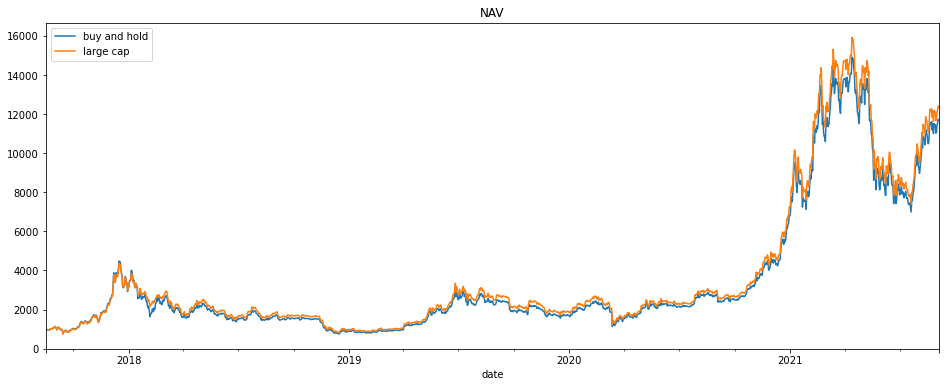

In [41]:
nav_df.plot(title='NAV', figsize=(16, 6))

## Drawdown

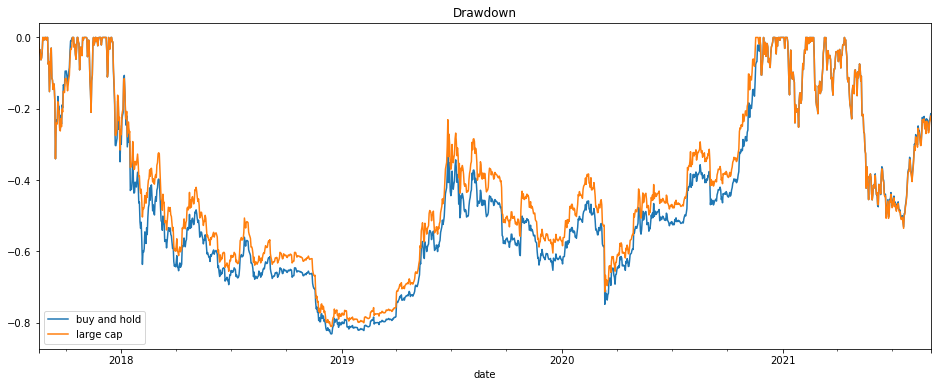

In [42]:
def drawdown(prices):
    cummax = prices.cummax()
    drawdown = (prices - cummax) / cummax
    return drawdown
drawdown_df = nav_df.apply(drawdown)

drawdown_df.plot(title='Drawdown', figsize=(16, 6))

## Asset value VS Cash

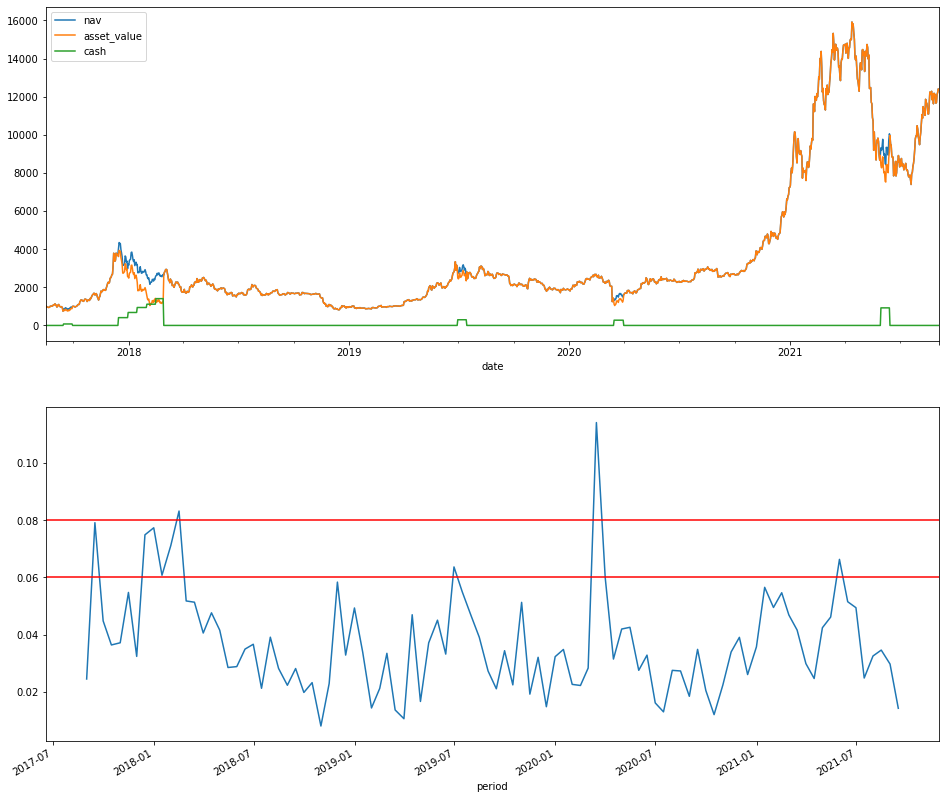

In [43]:
fig, axes = plt.subplots(2, figsize=(16, 15))
portfolio_price_df.plot(y=['nav', 'asset_value', 'cash'], ax=axes[0])
periodically_return_stds.plot(ax=axes[1])

axes[1].axhline(y=0.08, color='r', linestyle='-')
axes[1].axhline(y=0.06, color='r', linestyle='-')

## Export result

In [44]:
nav_df.to_excel('Large_Cap_BTC_NAV.xlsx')
drawdown_df.to_excel('Large_Cap_BTC_Drawdown.xlsx')

# ETH

In [45]:

price_df = pd.read_csv('dataset/ETHUSDT-1min.csv',
                 index_col='date',
                 parse_dates=['date'])
price_df = price_df[['open', 'high', 'low', 'close']]
price_df.index = price_df.index.map(lambda ts: pd.Timestamp(ts.year, ts.month, ts.day, ts.hour, ts.minute, 0))
price_df.sort_index(inplace=True)
price_df

,open,high,low,close
date,,,,
2017-08-17 04:00:00,301.13,301.13,301.13,301.13
2017-08-17 04:01:00,301.13,301.13,301.13,301.13
2017-08-17 04:02:00,300.00,300.00,300.00,300.00
2017-08-17 04:03:00,300.00,300.00,300.00,300.00
2017-08-17 04:04:00,301.13,301.13,301.13,301.13
...,...,...,...,...
2021-09-05 14:27:00,3930.39,3932.62,3930.01,3931.24
2021-09-05 14:28:00,3931.23,3931.79,3929.47,3931.78
2021-09-05 14:29:00,3931.78,3932.00,3930.08,3930.23


In [46]:
price_df

,open,high,low,close
date,,,,
2017-08-17 04:00:00,301.13,301.13,301.13,301.13
2017-08-17 04:01:00,301.13,301.13,301.13,301.13
2017-08-17 04:02:00,300.00,300.00,300.00,300.00
2017-08-17 04:03:00,300.00,300.00,300.00,300.00
2017-08-17 04:04:00,301.13,301.13,301.13,301.13
...,...,...,...,...
2021-09-05 14:27:00,3930.39,3932.62,3930.01,3931.24
2021-09-05 14:28:00,3931.23,3931.79,3929.47,3931.78
2021-09-05 14:29:00,3931.78,3932.00,3930.08,3930.23


In [47]:

buy_and_hold_price_df = buy_and_hold_by_ratio(price_df, asset_ratio=1.0, capital=CAPITAL).resample('1d').last()
buy_and_hold_price_df

,open,high,low,close,asset_amount,asset_value,cash,nav
date,,,,,,,,
2017-08-17,302.00,302.00,302.00,302.00,3.320825,1002.889118,0.0,1002.889118
2017-08-18,293.96,293.96,293.96,293.96,3.320825,976.189686,0.0,976.189686
2017-08-19,290.91,290.91,290.91,290.91,3.320825,966.061170,0.0,966.061170
2017-08-20,299.10,299.10,299.10,299.10,3.320825,993.258725,0.0,993.258725
2017-08-21,323.29,323.29,323.29,323.29,3.320825,1073.589480,0.0,1073.589480
...,...,...,...,...,...,...,...,...
2021-09-01,3831.30,3837.35,3826.82,3826.82,3.320825,12708.199117,0.0,12708.199117
2021-09-02,3788.01,3788.45,3785.06,3785.82,3.320825,12572.045296,0.0,12572.045296
2021-09-03,3938.88,3938.89,3934.49,3938.11,3.320825,13077.773719,0.0,13077.773719


count    98.000000
mean      0.047866
std       0.020780
min       0.012928
25%       0.035455
50%       0.045046
75%       0.054576
max       0.140304
Name: return, dtype: float64

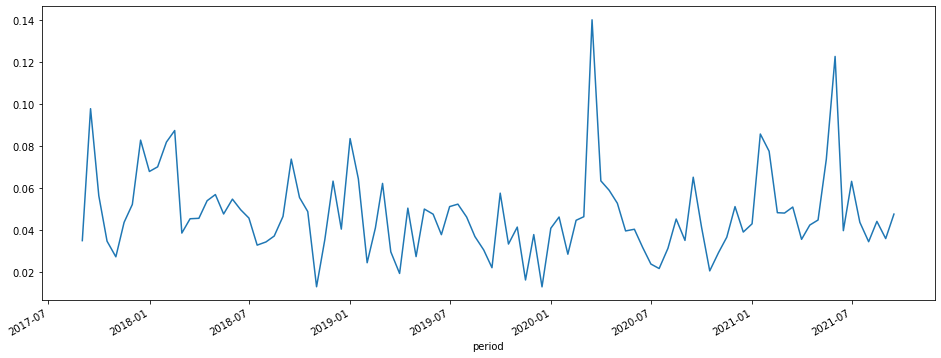

In [48]:
broker = Broker(price_df, capital=CAPITAL, asset_ratio=1.0, fee=FEE)
periodically_return_stds = calculate_half_month_std(price_df)
periodically_return_stds.plot(figsize=(16, 6))
periodically_return_stds.describe()

## Take action

In [49]:
is_reduce_voltality_phrase = False
for period, std in periodically_return_stds.items():
        
    if period > price_df.index.max():
        break
        
    price = price_df.loc[period, 'close']
    
    if std >= 0.14:
        print(period, std, 'sell 30%', )
        # Sell 30% of current asset amount
        sell_asset_ratio = 0.30
        broker.sell(price,
                    asset_amount=broker.asset_amount*sell_asset_ratio,
                    dt=period)
        is_reduce_voltality_phrase = True
    elif std >= 0.11:
        print(period, std, 'sell 20%', )
        # Sell 20% of current asset amount
        sell_asset_ratio = 0.20
        broker.sell(price,
            asset_amount=broker.asset_amount*sell_asset_ratio,
            dt=period)
        is_reduce_voltality_phrase = True
    elif std >= 0.09:
        print(period, std, 'sell 10%', )
        # Sell 10% of current asset amount
        sell_asset_ratio = 0.10
        broker.sell(price,
            asset_amount=broker.asset_amount*sell_asset_ratio,
            dt=period)
        is_reduce_voltality_phrase = True
    else:
        if is_reduce_voltality_phrase:
            print(period, std, 'buy back', broker.cash/price)
            is_reduce_voltality_phrase = False
            
            # Buy back with all of current cash
            broker.buy(price,
                asset_amount=int(broker.cash)/price,
                dt=period)
    
        

2017-09-15 13:00:00 0.09790738132824307 sell 10%
2017-09-30 13:00:00 0.056383205936230404 buy back 0.24881250641617034
2020-03-15 13:00:00 0.1403038464039491 sell 30%
2020-03-31 13:00:00 0.0634857717804228 buy back 0.918275407157533
2021-05-31 13:00:00 0.1228259736264483 sell 20%
2021-06-15 13:00:00 0.03972348589219289 buy back 0.6231486942304508


In [50]:
portfolio_df = broker.export_transaction()
portfolio_price_df = broker.export_price().resample('1d').last()

In [51]:
portfolio_df

,nav,asset_value,asset_amount,cash,price,action,position_value,posterior_asset_value,posterior_asset_amount,posterior_cash,posterior_nav
date,,,,,,,,,,,
2017-08-17 04:00:00,1000.000000,1000.000000,3.320825,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-15 13:00:00,753.827251,753.827251,3.320825,0.000000,227.00,Sell,-75.382725,678.444526,2.988742,75.382725,753.827251
2017-09-30 13:00:00,980.882011,905.499286,2.988742,75.382725,302.97,Buy,75.000000,980.499286,3.236292,0.382725,980.882011
2020-03-15 13:00:00,404.433740,404.051014,3.236292,0.382725,124.85,Sell,-121.215304,282.835710,2.265404,121.598029,404.433740
2020-03-31 13:00:00,421.582849,299.984820,2.265404,121.598029,132.42,Buy,121.000000,420.984820,3.179163,0.598029,421.582849
2021-05-31 13:00:00,8084.956266,8084.358236,3.179163,0.598029,2542.92,Sell,-1616.871647,6467.486589,2.543331,1617.469677,8084.956266
2021-06-15 13:00:00,8219.040662,6601.570985,2.543331,1617.469677,2595.64,Buy,1617.000000,8218.570985,3.166298,0.469677,8219.040662


## NAV

In [52]:
nav_df = pd.DataFrame()
nav_df['buy and hold'] = buy_and_hold_price_df['nav']
nav_df['large cap'] = portfolio_price_df['nav']

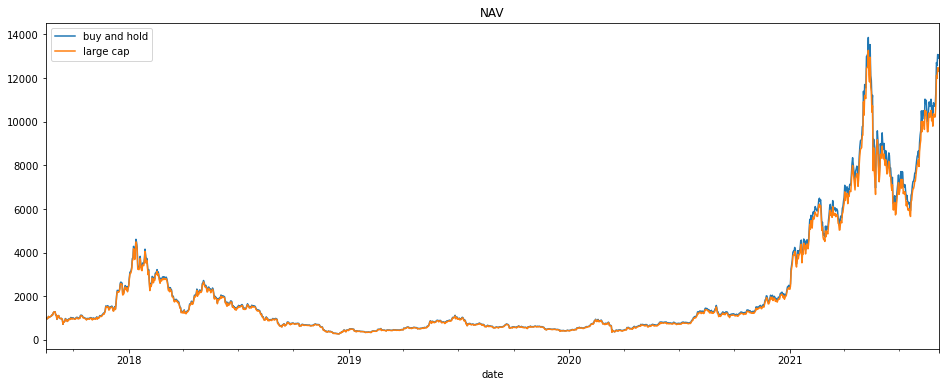

In [53]:
nav_df.plot(title='NAV', figsize=(16, 6))

## Drawdown

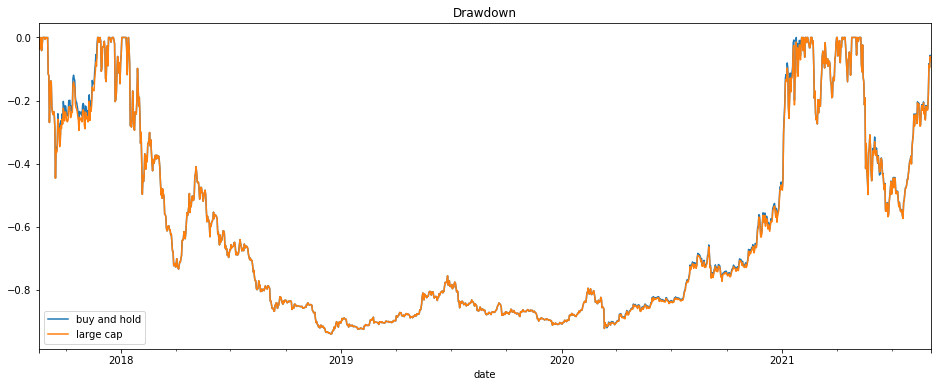

In [54]:
def drawdown(prices):
    cummax = prices.cummax()
    drawdown = (prices - cummax) / cummax
    return drawdown
drawdown_df = nav_df.apply(drawdown)

drawdown_df.plot(title='Drawdown', figsize=(16, 6))

## Asset value VS Cash

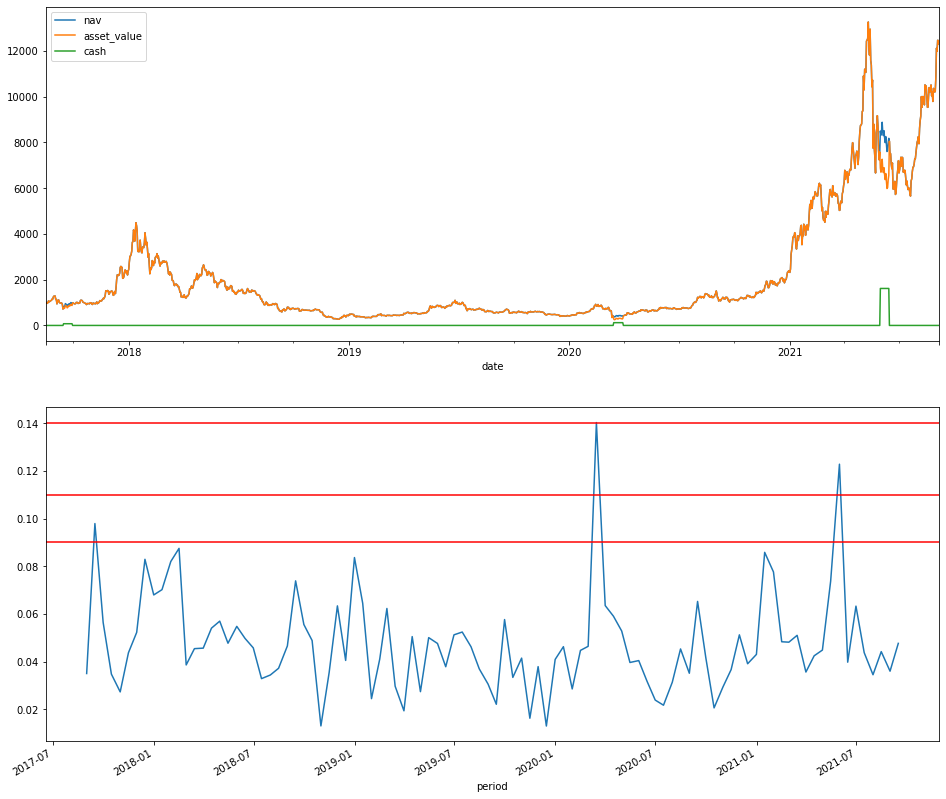

In [55]:
fig, axes = plt.subplots(2, figsize=(16, 15))
portfolio_price_df.plot(y=['nav', 'asset_value', 'cash'], ax=axes[0])


periodically_return_stds.plot(ax=axes[1])
axes[1].axhline(y=0.14, color='r', linestyle='-')
axes[1].axhline(y=0.11, color='r', linestyle='-')
axes[1].axhline(y=0.09, color='r', linestyle='-')

## Export result

In [56]:
nav_df.to_excel('Large_Cap_ETH_NAV.xlsx')
drawdown_df.to_excel('Large_Cap_ETH_Drawdown.xlsx')